In [1]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from matplotlib import pyplot as plt
from matplotlib import patches
import plotly.graph_objects as go
import plotly.express as px

In [7]:
dataset_base_path = '../data/clevr/CLEVR_CoGenT_v1.0/images/' 
x_train = []
for img in os.listdir(dataset_base_path + 'trainA'):
    x_train.append(dataset_base_path + 'trainA/' + img)
x_val = []
for img in os.listdir(dataset_base_path + 'valA'):
    x_val.append(dataset_base_path + 'valA/' + img)

print('Number of training images: ', len(x_train))
print('Number of validation images: ', len(x_val))

Number of training images:  70000
Number of validation images:  15000


In [8]:
DATA_PROPORTION = 0.1
x_train = x_train[:int(DATA_PROPORTION * len(x_train))]
x_val = x_val[:int(DATA_PROPORTION * len(x_val))]
print('Number of training images: ', len(x_train))
print('Number of validation images: ', len(x_val))

Number of training images:  7000
Number of validation images:  1500


(320, 480, 4)


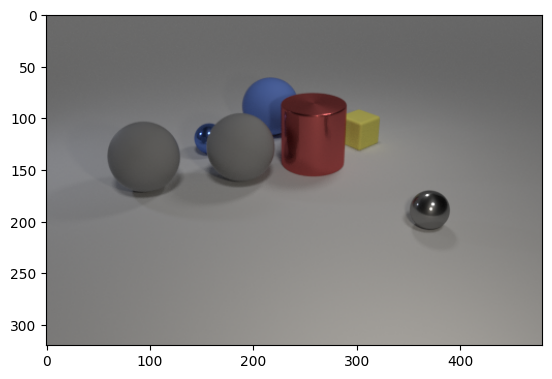

In [9]:
idx = random.randint(0, len(x_train))
img = plt.imread(x_train[idx])
INPUT_SHAPE = img.shape
print(INPUT_SHAPE)
plt.imshow(img)
plt.show()

In [10]:
def preprocess_image(image):
    # Resize the image (224, 224)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    # Convert to float and normalize
    image = image.astype(np.float32) / 255
    # Convert to tensor
    image = torch.from_numpy(image).permute(2, 0, 1)
    return image

In [11]:
x_train = [preprocess_image(cv2.imread(img)) for img in x_train]
x_val = [preprocess_image(cv2.imread(img)) for img in x_val]

In [18]:
# Create the training dataset and the data loader
train_dataset = TensorDataset(train_text, train_image, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create the validation dataset and the data loader
val_dataset = TensorDataset(val_text, val_image, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [19]:
class IntraModelAttention(nn.Module):
    def __init__(self, input_size):
        super(IntraModelAttention, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size // 2)
        self.fc2 = nn.Linear(input_size // 2, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [20]:
class MyModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, num_classes):
        super(MyModel, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        self.text_gru = nn.GRU(input_size=self.vocab_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.image_resnet = fasterrcnn_resnet50_fpn(
            weights='DEFAULT',
            num_classes=91,
            weights_backbone='DEFAULT',
            trainable_backbone_layers=0,
        )
        self.image_resnet = nn.Sequential(*list(self.image_resnet.children())[:-2])
        self.text_attention = IntraModelAttention(self.hidden_size)
        self.image_attention = IntraModelAttention(self.hidden_size)
        self.fc = nn.Linear(self.hidden_size * 2, self.num_classes)

    # def forward(self, text, image):
    #     text, _ = self.text_gru(text)
    #     text = text[:, -1, :]
    #     text = text.unsqueeze(0)
    #     image = self.image_resnet(image)
    #     image = image.view(image.size(0), -1)
    #     text_attention = self.text_attention(text)
    #     image_attention = self.image_attention(image)
    #     text = text * text_attention
    #     image = image * image_attention
    #     concat = torch.cat((text, image), dim=1)
    #     logits = self.fc(concat)
    #     return logits

    def forward(self, image):
        image = self.image_resnet(image)
        image = image.view(image.size(0), -1)
        image_attention = self.image_attention(image)
        image = image * image_attention
        logits = self.fc(image)
        return logits

In [21]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [22]:
# weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
# labels = {i: weights.meta["categories"][i] for i in range(1, 91)}
# labels

In [23]:
# Initialize the model
vocab_size = 1000  # adjust to your vocabulary size
hidden_size = 256  # adjust to your desired hidden size
num_layers = 2  # adjust to your desired number of GRU layers
num_classes = 10  # adjust to your number of classes
model = MyModel(vocab_size, hidden_size, num_layers, num_classes)

In [24]:
# Define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # adjust the number of epochs
    running_loss = 0.0
    # for i, (text, image, label) in enumerate(train_loader):
    for i, (image, label) in enumerate(train_loader):
        # Zero the gradient
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(text, image)
        loss = criterion(logits, label)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[Epoch %d, Mini-batch %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

TypeError: 'function' object is not iterable

In [ ]:
# Test the model on the validation set
with torch.no_grad():
    correct = 0
    total = 0
    for text, image, label in val_loader:
        logits = model(text, image)
        _, predicted = torch.max(logits.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    print('Accuracy of the model on the validation set: %d %%' % (100 * correct / total))
